# Test Three for the Classical SRNN

This is a notebook for testing the classical SRNN.

## Import everything

Modify setting for pytorch

In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
currentPath=os.getcwd()

Import matplotlib and others

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import torch

Import the classical SRNN and others

In [3]:
#Modify path for the notebooks
currentPath=os.path.join(currentPath,'..')
currentPath=os.path.join(currentPath,'src')
os.chdir(currentPath)

In [4]:
from DataGenerator.HenonMapDataGen import HenonMapDataGen
from ClassicalModels.ClassicalSRNNs import ClassicalSRNN
from ClassicalModels.ClassicalSRNNs import SuportFunction
from GradientFreeOptimizers.CostFunc import GradFreeMSELoss
import GradientFreeOptimizers.Helpers as hp

## Test Three

### Get the data

#### Set save path

In [5]:
savepath=os.path.join(currentPath,'..\data\HenonMap\Test')
filename='ClassicalSRNNTest1.csv'

In [6]:
'''
hmap=HenonMapDataGen(savepath=savepath)
hmap(10000)
hmap.save_to_CSV(filename)
''';

#### Read the data

In [7]:
hmap=HenonMapDataGen(savepath=savepath)
hmap.read_from_CSV(filename)

In [8]:
print(hmap)

Data Info:
----------------------------------------
Data Size: 10000
Data Interval: 1
Data ParamA: 1.4, Data ParamB: 0.3
Data Bound: -1.2
Data HeavyMem: True
Data Seed:
 [0.004080481176836049, 0.06596289908127698]
----------------------------------------


#### Generate the data iter

In [9]:
testSetRatio=0.2
numStep=10
batchSize=4

In [10]:
trainIter,testIter=hmap.get_data_iter(testSetRatio,numStep,batchSize,mask=0,shuffle=False)

In [11]:
X,Y=next(iter(trainIter))
print('Train Data Size:',len(trainIter))

Train Data Size: 796


In [12]:
X,Y=next(iter(testIter))
print('Test Data Size:',len(testIter))

Test Data Size: 200


### Define the SRNN

#### Get neccesary functions

In [13]:
srnnTestSup=SuportFunction()

In [14]:
transform=lambda Xs:[torch.squeeze(x) for x in Xs]

In [15]:
init_rnn_state=srnnTestSup.get_init_state_fun(initStateValue=0.0)
get_params=srnnTestSup.get_get_params_fun(inactive=['J'])
rnn=srnnTestSup.get_forward_fn_fun(activation=torch.tanh,isTypical=True)
predict_fun=srnnTestSup.get_predict_fun(outputTransoform=transform)

#### Create the SRNN

In [16]:
inputSize=outputSize=1
hiddenSize=10

In [17]:
net=ClassicalSRNN(inputSize,hiddenSize,outputSize,get_params,init_rnn_state,rnn)

#### Test prediction

In [18]:
state=net.begin_state(batchSize)
Y,newState=net(X,state)
Y.shape, len(newState), newState[0].shape

(torch.Size([40, 1]), 1, torch.Size([4, 10]))

In [19]:
preX,preY=hmap.data_as_tensor
preX,preY=torch.unsqueeze(preX[:2],-1),torch.unsqueeze(preY[:10],-1)
print('preX=',preX)
preY=[y for y in torch.cat((preX[:2],preY[1:]),dim=0)]
print('preY=',preY)

preX= tensor([[0.0041],
        [0.0660]])
preY= [tensor([0.0041]), tensor([0.0660]), tensor([0.9951]), tensor([-0.3666]), tensor([1.1104]), tensor([-0.8361]), tensor([0.3545]), tensor([0.5733]), tensor([0.6463]), tensor([0.5872]), tensor([0.7111])]


In [20]:
preX=torch.unsqueeze(preX,-1)
YHat=predict_fun(preX,net,numPreds=5)
print('YHat=',YHat)

YHat= [tensor(0.0041), tensor(0.0660), tensor(2.7467e-06), tensor(-5.8167e-07), tensor(-5.8227e-08), tensor(-5.8176e-09), tensor(-5.8125e-10)]


### Train the network

#### Parameters

In [21]:
num_epochs, lr = 600, 0.01

#### Loss function

In [22]:
lossFunc=GradFreeMSELoss(net)

#### Trainer

In [23]:
trainer = torch.optim.SGD(net.params, lr=lr)
scheduler=torch.optim.lr_scheduler.StepLR(trainer,step_size=200,gamma=0.1)

#### Initial loss

In [24]:
l_epochs=[]
train_l=SuportFunction.evaluate_accuracy(net,trainIter,lossFunc,False)
test_l=SuportFunction.evaluate_accuracy(net,testIter,lossFunc,False)
l_epochs.append([train_l,test_l])
print('Initial Train Loss:',train_l)
print('Initial Test Loss:',test_l)

Initial Train Loss: 0.5854705534987713
Initial Test Loss: 0.5812979756569375


#### Training

TestLoss 0.006719, 13977.027422 point/s
Prediction:
 [tensor(0.0041), tensor(0.0660), tensor(1.0948), tensor(-0.6843), tensor(0.5104), tensor(0.4490), tensor(0.8898), tensor(-0.0470), tensor(1.2921), tensor(-1.1657), tensor(-0.4767)]
Answer:
 [tensor([0.0041]), tensor([0.0660]), tensor([0.9951]), tensor([-0.3666]), tensor([1.1104]), tensor([-0.8361]), tensor([0.3545]), tensor([0.5733]), tensor([0.6463]), tensor([0.5872]), tensor([0.7111])]


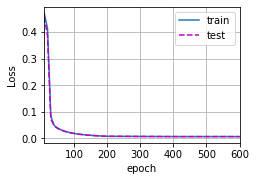

In [25]:
animator = hp.Animator(xlabel='epoch', ylabel='Loss',
                            legend=['train','test'], xlim=[10, num_epochs])
    # prediction
predict = lambda prefix: predict_fun(prefix,net, numPreds=9)
# train and predict
for epoch in range(num_epochs):
    trainLoss, speed = SuportFunction.train_epoch(
        net, trainIter, lossFunc, trainer, False)
    testLoss=SuportFunction.evaluate_accuracy(net, testIter, lossFunc, False)
    if (epoch + 1) % 10 == 0:
        print(predict(preX))
        #print(net.params)
        #print(net.constants)
        animator.add(epoch + 1, [trainLoss,testLoss])
    l_epochs.append([trainLoss,testLoss])
    scheduler.step()
testLoss=SuportFunction.evaluate_accuracy(net, testIter, lossFunc, False)
print(f'TestLoss {testLoss:f}, {speed:f} point/s')
print('Prediction:\n',predict(preX))
print('Answer:\n',preY)

### Visualize the performance

#### One Step Prediction

In [26]:
X,Y=next(iter(testIter))
state=net.begin_state(batchSize)
Y_hat,newState=net(X,state)
print('X=',torch.squeeze(X))
print('Prediction=',torch.squeeze(Y_hat).detach())
Y=Y.transpose(0,1).reshape([-1,Y.shape[-1]])
print('Y=',torch.squeeze(Y))



X= tensor([[ 0.7001,  0.1118,  1.1925, -0.9575,  0.0743,  0.7050,  0.3264,  1.0623,
         -0.4821,  0.9933],
        [-0.4698,  0.4264,  0.6045,  0.6164,  0.6494,  0.5945,  0.7001,  0.4921,
          0.8710,  0.0856],
        [ 0.7391,  0.3097,  1.0875, -0.5627,  0.8829, -0.2601,  1.1701, -0.9949,
         -0.0348,  0.6998],
        [ 1.2313, -1.1317, -0.4238,  0.4090,  0.6386,  0.5517,  0.7654,  0.3454,
          1.0626, -0.4773]])
Prediction= tensor([ 0.1656,  0.6203,  0.0757, -1.1250,  1.2499,  0.6344,  1.1280, -0.4145,
        -0.8968,  0.5914, -0.5846,  0.4952, -0.0424,  0.6322,  0.7386,  0.6551,
         0.8262,  0.5702, -0.3346,  0.5151,  0.2602,  0.6924,  1.1267,  0.7671,
         1.1113,  0.4543, -0.9479,  0.2912, -0.5163,  0.8921, -0.1287,  1.1138,
         0.8712,  0.0174,  0.8226, -0.5103, -0.5825,  1.3022,  0.2359,  0.8792])
Y= tensor([ 0.1118,  0.4264,  0.3097, -1.1317,  1.1925,  0.6045,  1.0875, -0.4238,
        -0.9575,  0.6164, -0.5627,  0.4090,  0.0743,  0.6494,  0

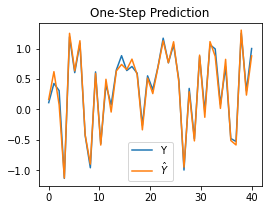

In [27]:
#Visualize the data
axes,fig=plt.subplots(1,1,figsize=(4,3))
plt.title('One-Step Prediction')
plt.plot(torch.linspace(0,Y.numel(),Y.numel()),torch.squeeze(Y),label='Y')
plt.plot(torch.linspace(0,Y.numel(),Y.numel()),torch.squeeze(Y_hat).detach(),label=r'$\hat{Y}$')
plt.legend();

In [28]:
print(net.constants)

[tensor([], size=(1, 0)), tensor([]), tensor([[0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
         0.0100],
        [0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
         0.0100],
        [0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
         0.0100],
        [0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
         0.0100],
        [0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
         0.0100],
        [0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
         0.0100],
        [0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
         0.0100],
        [0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
         0.0100],
        [0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
         0.0100],
        [0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100

#### Multi Step Prediction

In [41]:
prefixSize=10
totalSize=40
testShift=int(len(hmap)*(1-testSetRatio))

In [42]:
preX,preY=hmap.data_as_tensor
preX,preY=torch.unsqueeze(preX[testShift:testShift+prefixSize],-1),torch.unsqueeze(preY[testShift:testShift+totalSize-1],-1)
#print('preX=',preX)
preY=[y for y in torch.cat((preX[:2],preY[1:]),dim=0)]
#print('preY=',preY)
len(preY)

40

In [43]:
preX=torch.unsqueeze(preX,-1)
YHat=predict_fun(preX,net,numPreds=totalSize-prefixSize)
#print('YHat=',YHat)
len(YHat)

40

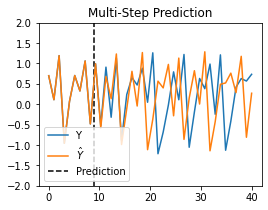

In [44]:
#Visualize the data
axes,fig=plt.subplots(1,1,figsize=(4,3))
plt.title('Multi-Step Prediction')
fig.set_ylim(-2,2)
plt.plot(torch.linspace(0,len(preY),len(preY)),preY,label='Y')
plt.plot(torch.linspace(0,len(preY),len(preY)),YHat,label=r'$\hat{Y}$')
plt.vlines([prefixSize-1],ymin=-2,ymax=2,linestyles='dashed',label='Prediction')
plt.legend();

# End of the test